In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc, auc, classification_report, confusion_matrix


In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [3]:
trainds = pd.read_csv('NSL-KDD/KDDTrain+.txt', names=col_names, encoding='latin-1')
testds = pd.read_csv('NSL-KDD/KDDTest+.txt', names=col_names, encoding='latin-1')
df = pd.concat([trainds, testds])

In [4]:
df.drop(['difficulty_level'],axis=1,inplace=True)

In [5]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148517 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13  

In [6]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## Pre processing

### Hierarchy Generation

In [7]:
df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

### Standadization

In [8]:
#selection of numeric attribute columns from the dataset
numcol = df.select_dtypes(include = 'number').columns

from sklearn.preprocessing import StandardScaler

#normalizing using standard scalar
std_scalar = StandardScaler()
for i in numcol:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scalar.fit_transform(arr.reshape(len(arr),1))

In [9]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.849240,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,normal
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.065006,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.840250,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,Dos
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,normal
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal


### One Hot Encoding

In [10]:
categ_col = ['protocol_type','service','flag']
ctg = df[categ_col]

#one-hot encoding of categorical attributes
ctg = pd.get_dummies(ctg, columns = categ_col)

In [11]:
ctg

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22540,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22541,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22542,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Binary Classification

This is used for all of the 4 Artificial Neural Network Algorithms since we aim to do Binary Classification of the label either as attack or normal connection.

In [12]:
#categorize attack labels into 'normal' and 'attack'
biny_lbl = pd.DataFrame(df.label.map(lambda x:'normal' if x=='normal' else 'attack'))

In [13]:
#create dataframe with binary label
bin_dataset = df.copy()
bin_dataset['label'] = biny_lbl

In [14]:
#perform label encoding with binary labels
from sklearn import preprocessing

label_one = preprocessing.LabelEncoder()
encode_label = biny_lbl.apply(label_one.fit_transform)
bin_dataset['intrusion'] = encode_label

In [15]:
#one-hot encoding of the attack label
bin_dataset = pd.get_dummies(bin_dataset, columns = ['label'], prefix = "", prefix_sep = "")
bin_dataset['label'] = biny_lbl
bin_dataset

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,attack,normal,label
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,1,0,1,normal
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,1,0,1,normal
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,0,1,0,attack
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,1,0,1,normal
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,1,0,1,normal
22540,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,1,0,1,normal
22541,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,0,1,0,attack
22542,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,1,0,1,normal


### Multi-class Classification

This can be used to classify the connection as what type of attact it is. We don't use this in next 4 deep learning algorithms

In [16]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = df.copy()
multi_label = pd.DataFrame(multi_data.label)


In [17]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
labencd = preprocessing.LabelEncoder()
enc_label = multi_label.apply(labencd.fit_transform)
multi_data['intrusion'] = enc_label


In [18]:
labencd.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [19]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="") 
multi_data['label'] = multi_label
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,Dos,Probe,R2L,U2R,normal,label
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.584813,-0.267151,-0.406815,4,0,0,0,0,1,normal
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.584813,-0.422074,-0.406815,4,0,0,0,0,1,normal
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,1.742295,-0.422074,-0.406815,0,1,0,0,0,0,Dos
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.561542,-0.422074,-0.376989,4,0,0,0,0,1,normal
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.584813,-0.422074,-0.406815,4,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.584813,-0.422074,-0.406815,4,0,0,0,0,1,normal
22540,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.584813,-0.422074,-0.406815,4,0,0,0,0,1,normal
22541,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,-0.584813,-0.205182,-0.198035,0,1,0,0,0,0,Dos
22542,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.584813,-0.422074,-0.406815,4,0,0,0,0,1,normal


### Feature Extraction

In [20]:
#creation of dataframe constrained to numeric attributes of encoded label attributes and binary class dataset 
numeric_bin = bin_dataset[numcol].copy()
numeric_bin['intrusion'] = bin_dataset['intrusion'].copy()

In [21]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr= numeric_bin.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)


count                       0.524108
srv_serror_rate             0.586636
serror_rate                 0.588474
dst_host_serror_rate        0.589936
dst_host_srv_serror_rate    0.593690
logged_in                   0.664117
dst_host_same_srv_rate      0.667624
dst_host_srv_count          0.692577
same_srv_rate               0.708911
intrusion                   1.000000
Name: intrusion, dtype: float64

In [22]:
# selecting attributes found by using pearson correlation coefficient
numeric_bin = bin_dataset[['count','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate','logged_in','dst_host_same_srv_rate','dst_host_srv_count','same_srv_rate']]
     

In [23]:
ctg

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22540,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22541,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22542,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_bin = pd.concat([numeric_bin, ctg], axis=1)

# then joining encoded, one-hot-encoded, and original attack label attribute
bin_dataset = pd.concat([numeric_bin, bin_dataset[['intrusion','attack','normal','label']]], axis=1)

In [25]:
bin_dataset.head(5)

,count,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,logged_in,dst_host_same_srv_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,intrusion,attack,normal,label
0,-0.696611,-0.590270,-0.594848,-0.597720,-0.584813,-0.821249,-0.813554,-0.849240,0.749108,0,...,0,0,0,0,1,0,1,0,1,normal
1,-0.602401,-0.590270,-0.594848,-0.597720,-0.584813,-0.821249,-1.192968,-1.065006,-1.358363,0,...,0,0,0,0,1,0,1,0,1,normal
2,0.339700,1.721459,1.720415,1.736012,1.742295,-0.821249,-0.969783,-0.840250,-1.427085,0,...,1,0,0,0,0,0,0,1,0,attack
3,-0.670918,-0.127924,-0.131796,-0.527708,-0.561542,1.217658,1.038878,1.218511,0.749108,0,...,0,0,0,0,1,0,1,0,1,normal
4,-0.456804,-0.590270,-0.594848,-0.597720,-0.584813,1.217658,1.038878,1.218511,0.749108,0,...,0,0,0,0,1,0,1,0,1,normal


In [26]:

# creating a dataframe with only numeric attributes of multi-class dataset and encoded label attribute 
numeric_multi = multi_data[numcol]
numeric_multi['intrusion'] = multi_data['intrusion']

C:\Users\dharaneish\AppData\Local\Temp\ipykernel_18464\721849191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_multi['intrusion'] = multi_data['intrusion']


In [27]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr = numeric_multi.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.574230
srv_serror_rate             0.661598
serror_rate                 0.663323
dst_host_serror_rate        0.664444
dst_host_srv_serror_rate    0.668538
logged_in                   0.674268
dst_host_srv_count          0.692689
dst_host_same_srv_rate      0.697193
same_srv_rate               0.769654
intrusion                   1.000000
Name: intrusion, dtype: float64

In [28]:
# selecting attributes found by using pearson correlation coefficient
numeric_multi = multi_data[['count','logged_in','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_srv_count','same_srv_rate']]


In [29]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_multi = pd.concat([numeric_multi, ctg], axis=1)

# then joining encoded, one-hot-encoded, and original attack label attribute
multi_data = pd.concat([numeric_multi, multi_data[['intrusion','Dos','Probe','R2L','U2R','normal','label']]], axis=1)


In [30]:
multi_data

,count,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S3,flag_SF,flag_SH,intrusion,Dos,Probe,R2L,U2R,normal,label
0,-0.696611,-0.821249,-0.590270,-0.594848,-0.597720,-0.813554,-0.584813,-0.849240,0.749108,0,...,0,1,0,4,0,0,0,0,1,normal
1,-0.602401,-0.821249,-0.590270,-0.594848,-0.597720,-1.192968,-0.584813,-1.065006,-1.358363,0,...,0,1,0,4,0,0,0,0,1,normal
2,0.339700,-0.821249,1.721459,1.720415,1.736012,-0.969783,1.742295,-0.840250,-1.427085,0,...,0,0,0,0,1,0,0,0,0,Dos
3,-0.670918,1.217658,-0.127924,-0.131796,-0.527708,1.038878,-0.561542,1.218511,0.749108,0,...,0,1,0,4,0,0,0,0,1,normal
4,-0.456804,1.217658,-0.590270,-0.594848,-0.597720,1.038878,-0.584813,1.218511,0.749108,0,...,0,1,0,4,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.705176,1.217658,-0.590270,-0.594848,-0.574382,0.413961,-0.584813,0.193625,0.749108,0,...,0,1,0,4,0,0,0,0,1,normal
22540,-0.696611,1.217658,-0.590270,-0.594848,-0.574382,1.038878,-0.584813,1.218511,0.749108,0,...,0,1,0,4,0,0,0,0,1,normal
22541,-0.670918,1.217658,-0.590270,-0.594848,-0.597720,1.038878,-0.584813,1.218511,0.749108,0,...,0,1,0,0,1,0,0,0,0,Dos
22542,-0.679482,-0.821249,-0.590270,-0.594848,-0.597720,1.016560,-0.584813,1.191540,0.749108,0,...,0,1,0,4,0,0,0,0,1,normal


# Prediction Models

bin_dataset is sufficient for Deep Learning. first n-4 are x and intrusion is Y

In [31]:
df2 = bin_dataset.copy()
#df2.to_csv("bin_data.csv")

# ML

In [32]:
##create input and output vectors
X = df2.iloc[:,0:df2.shape[1]-4]
Y = df2[['intrusion']]
print(X.shape, Y.shape)
X = X.values.reshape(df2.shape[0], df2.shape[1]-4, 1)
Y = Y.values.reshape(df2.shape[0])
print(X.shape, Y.shape)

(148517, 93) (148517, 1)
(148517, 93, 1) (148517,)


In [33]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [34]:
print(X_train.shape, Y_train.shape)
print(X_test.shape,  Y_test.shape)

(118813, 93) (118813,)
(29704, 93) (29704,)


## SVM

In [37]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train, Y_train) 
y_pred = svclassifier.predict(X_test)

SVM Classification report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14233
           1       0.96      0.98      0.97     15471

    accuracy                           0.97     29704
   macro avg       0.97      0.97      0.97     29704
weighted avg       0.97      0.97      0.97     29704

SVM Confusion Matrix
[[13653   580]
 [  336 15135]]
Accuracy Score        =     0.9691624023700511
Precision Score       =     0.9630925867006045
Recall/Sensitivity    =     0.9782819468683343
Specificity           =     0.9592496311389026
F1 Score              =     0.9706278458282562


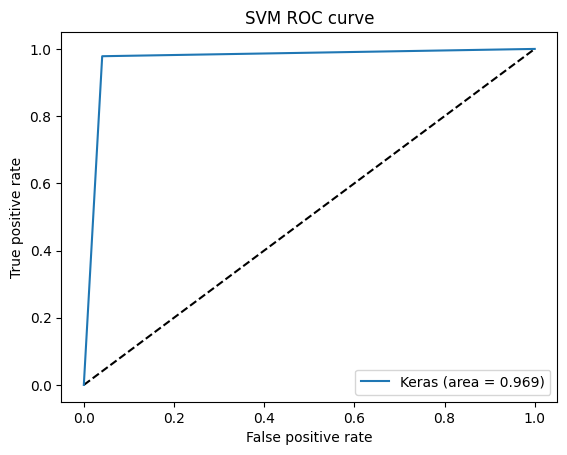

In [38]:
target_names = ['attack', 'normal']
print("SVM Classification report")
print(classification_report(Y_test, y_pred ))

print("SVM Confusion Matrix")
print(confusion_matrix(Y_test, y_pred ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test,y_pred))
print("Precision Score       =    ", precision_score(Y_test,y_pred))
print("Recall/Sensitivity    =    ", recall_score(Y_test,y_pred))
print("Specificity           =    ", recall_score(Y_test,y_pred,pos_label=0))
print("F1 Score              =    ", f1_score(Y_test,y_pred))

fpr, tpr, threshold = roc_curve(Y_test, y_pred)
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SVM ROC curve')
plt.legend(loc='best')
plt.show()

## XGBClassifier

In [35]:
import xgboost as xgb

# build model - Xgboost
xgb_mod=xgb.XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,Y_train) 

# make prediction and check model accuracy 
y_pred = xgb_mod.predict(X_test)

[20:05:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


XGBoost Classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     14233
           1       0.97      0.99      0.98     15471

    accuracy                           0.98     29704
   macro avg       0.98      0.98      0.98     29704
weighted avg       0.98      0.98      0.98     29704

XGBoost Confusion Matrix
[[13841   392]
 [  200 15271]]
Accuracy Score        =     0.9800700242391597
Precision Score       =     0.9749728659899125
Recall/Sensitivity    =     0.9870725874216275
Specificity           =     0.9724583713904307
F1 Score              =     0.9809854178711376


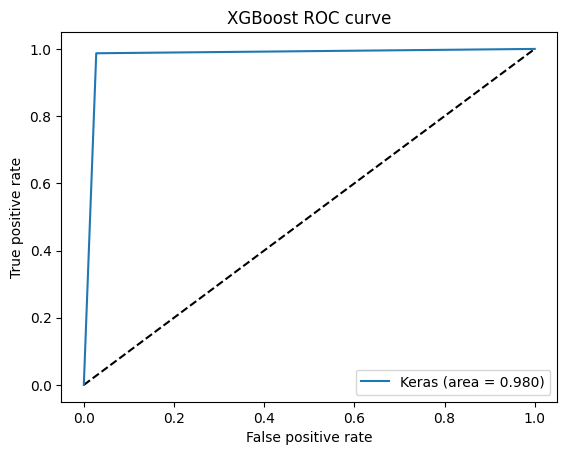

In [36]:
target_names = ['attack', 'normal']
print("XGBoost Classification report")
print(classification_report(Y_test, y_pred ))

print("XGBoost Confusion Matrix")
print(confusion_matrix(Y_test, y_pred ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test,y_pred))
print("Precision Score       =    ", precision_score(Y_test,y_pred))
print("Recall/Sensitivity    =    ", recall_score(Y_test,y_pred))
print("Specificity           =    ", recall_score(Y_test,y_pred,pos_label=0))
print("F1 Score              =    ", f1_score(Y_test,y_pred))

fpr, tpr, threshold = roc_curve(Y_test, y_pred)
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('XGBoost ROC curve')
plt.legend(loc='best')
plt.show()

# DL

In [37]:
##create input and output vectors
X = df2.iloc[:,0:df2.shape[1]-4]
Y = df2[['intrusion']]
print(X.shape, Y.shape)
X = X.values.reshape(df2.shape[0], df2.shape[1]-4, 1)
Y = Y.values.reshape(df2.shape[0], 1)
print(X.shape, Y.shape)

(148517, 93) (148517, 1)
(148517, 93, 1) (148517, 1)


In [38]:
Z = Y
Y = to_categorical(Y)
print(X.shape, Y.shape)

(148517, 93, 1) (148517, 2)


In [39]:
## splitting of training and testing data
#X_train,X_test,Y_train,Y_test = X[:125973, :], X[125973:, :], Y[:125973, :], Y[125973:, :]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [40]:
print(X_train.shape, Y_train.shape)
print(X_test.shape,  Y_test.shape)
print(X_val.shape, Y_val.shape)

(111387, 1, 93) (111387, 2)
(18565, 1, 93) (18565, 2)
(18565, 1, 93) (18565, 2)


In [41]:
sess1 = tf.compat.v1.Session()

## CNN

In [37]:
#CNN
model2 = Sequential()
model2.add(Conv1D(filters=256, kernel_size = 1, activation='tanh', dtype='float32', input_shape=(1,X.shape[1])))#256
model2.add(Conv1D(filters=128, kernel_size = 1, activation='tanh'))#128
model2.add(Conv1D(filters=64, kernel_size = 1, activation='tanh'))#64
model2.add(Conv1D(filters=32, kernel_size = 1, activation='tanh'))#32
model2.add(MaxPooling1D(pool_size=1))
model2.add(Flatten())
'''
model2.add(Conv1D(128, dropout=0.3, return_sequences=True)) #128
model2.add(Conv1D(64, dropout=0.3, return_sequences=True)) #64
model2.add(Conv1D(32))#32
'''
model2.add(Dense(100, activation='relu'))
model2.add((Dense(2, activation='softmax')))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted2= model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=2785, callbacks=callbacks_list)


Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.8945
Epoch 1: val_accuracy improved from -inf to 0.93951, saving model to weights.best.hdf5
40/40 [==============================] - 6s 73ms/step - loss: 0.2897 - accuracy: 0.8945 - val_loss: 0.1627 - val_accuracy: 0.9395
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9510
Epoch 2: val_accuracy improved from 0.93951 to 0.96095, saving model to weights.best.hdf5
40/40 [==============================] - 2s 57ms/step - loss: 0.1349 - accuracy: 0.9510 - val_loss: 0.1196 - val_accuracy: 0.9609
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9617
Epoch 3: val_accuracy improved from 0.96095 to 0.96208, saving model to weights.best.hdf5
40/40 [==============================] - 2s 54ms/step - loss: 0.1138 - accuracy: 0.9617 - val_loss: 0.1093 - val_accuracy: 0.9621
Epoch 4/100
39/40 [============================>.] - ETA: 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            24064     
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            32896     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             8256      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                        

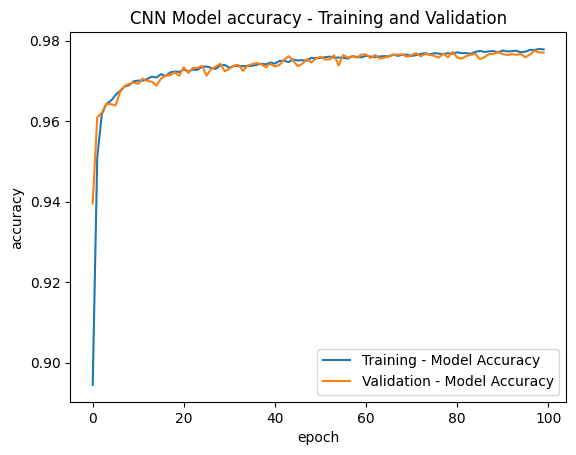

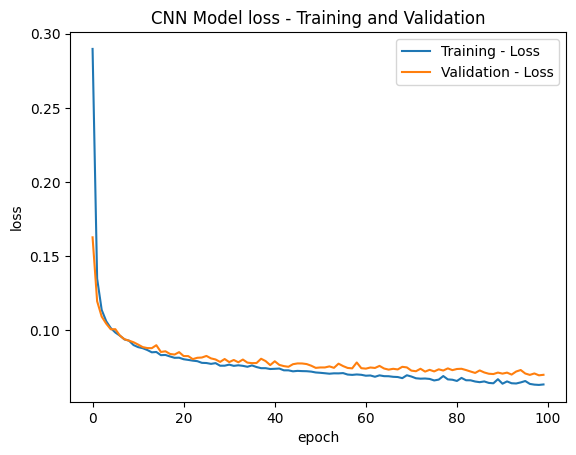

CNN Classification report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8993
           1       0.97      0.99      0.98      9572

    accuracy                           0.98     18565
   macro avg       0.98      0.98      0.98     18565
weighted avg       0.98      0.98      0.98     18565

CNN Confusion Matrix
[[8729  264]
 [ 136 9436]]
Accuracy Score        =     0.9784540802585511
Precision Score       =     0.9727835051546392
Recall/Sensitivity    =     0.9857918930213122
Specificity           =     0.9706438340931836
F1 Score              =     0.979244499792445


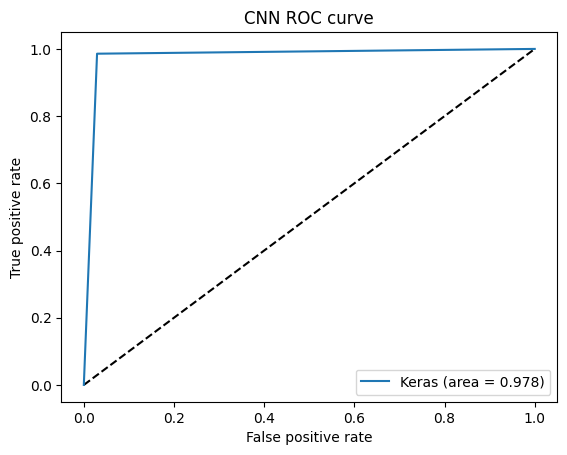

In [38]:
model2.summary()

y_pred = (model2.predict(X_test) > 0.5).astype("int32")
#y_pred = model2.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted2.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted2.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('CNN Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted2.history['loss'], label="Training - Loss")
plt.plot(predicted2.history['val_loss'], label="Validation - Loss")
plt.title('CNN Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("CNN Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("CNN Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve')
plt.legend(loc='best')
plt.show()


In [39]:
tf.keras.utils.plot_model(model2, to_file='CNN.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## RNN

In [40]:
#create model (RNN)
model3 = Sequential()
model3.add(SimpleRNN(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True)) #128
model3.add(SimpleRNN(64, dropout=0.3, return_sequences=True)) #64
model3.add(SimpleRNN(32))#32

'''
#(For Single Layer)
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model3.add(SimpleRNN(128))
'''

model3.add((Dense(2, activation='softmax')))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted3= model3.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=2785 ,callbacks=callbacks_list)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.8884
Epoch 1: val_accuracy improved from -inf to 0.93385, saving model to weights.best.hdf5
40/40 [==============================] - 11s 131ms/step - loss: 0.2810 - accuracy: 0.8884 - val_loss: 0.1722 - val_accuracy: 0.9339
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9238
Epoch 2: val_accuracy improved from 0.93385 to 0.94684, saving model to weights.best.hdf5
40/40 [==============================] - 5s 114ms/step - loss: 0.2042 - accuracy: 0.9238 - val_loss: 0.1476 - val_accuracy: 0.9468
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9286
Epoch 3: val_accuracy improved from 0.94684 to 0.95249, saving model to weights.best.hdf5
40/40 [==============================] - 5s 122ms/step - loss: 0.1935 - accuracy: 0.9286 - val_loss: 0.1389 - val_accuracy: 0.9525
Epoch 4/100
40/40 [==============================] - E

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 256)            89600     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 128)            49280     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 64)             12352     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 154,402
Trainable params: 154,402
Non-trainable params: 0
_________________________________________________________________
581/581 [==============================] - 3s 3m

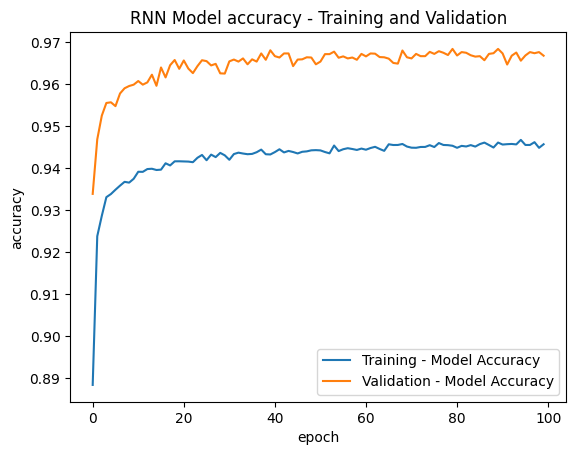

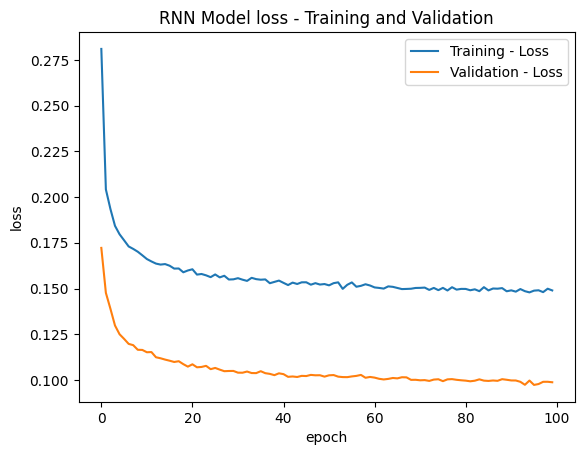

RNN Classification report
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      8993
           1       0.96      0.98      0.97      9572

    accuracy                           0.97     18565
   macro avg       0.97      0.97      0.97     18565
weighted avg       0.97      0.97      0.97     18565

RNN Confusion Matrix
[[8556  437]
 [ 168 9404]]
Accuracy Score        =     0.9674117963910585
Precision Score       =     0.955593943704908
Recall/Sensitivity    =     0.9824488090263268
Specificity           =     0.9514066496163683
F1 Score              =     0.9688353165404625


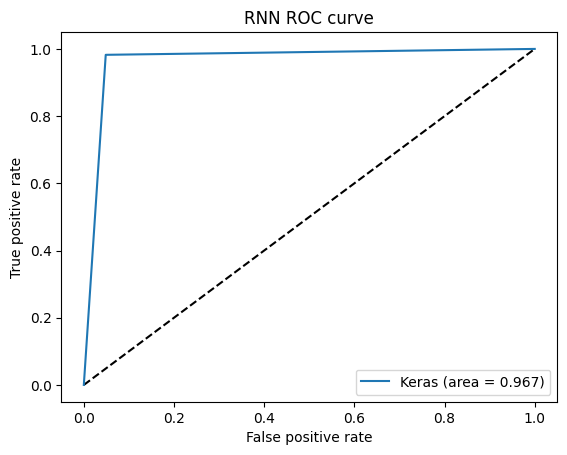

In [41]:
model3.summary()

y_pred = (model3.predict(X_test) > 0.5).astype("int32")
#y_pred = model3.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted3.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted3.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('RNN Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted3.history['loss'], label="Training - Loss")
plt.plot(predicted3.history['val_loss'], label="Validation - Loss")
plt.title('RNN Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("RNN Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("RNN Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RNN ROC curve')
plt.legend(loc='best')
plt.show()


In [42]:
tf.keras.utils.plot_model(model3, to_file='RNN.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## LSTM

In [43]:
# create the model (LSTM)
# For stacked Layer
embedding_vecor_length = 1
model = Sequential()
model.add(LSTM(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1]))) #256
model.add(LSTM(128, dropout=0.3, return_sequences=True)) #128
model.add(LSTM(64, dropout=0.3, return_sequences=True)) #64
model.add(LSTM(32)) #32

'''
(For Single Layer)
model.add(LSTM(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model.add(LSTM(128))
'''

model.add((Dense(2, activation='softmax')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=2785, callbacks=callbacks_list)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.5920 - accuracy: 0.7782
Epoch 1: val_accuracy improved from -inf to 0.89292, saving model to weights.best.hdf5
40/40 [==============================] - 33s 507ms/step - loss: 0.5920 - accuracy: 0.7782 - val_loss: 0.3688 - val_accuracy: 0.8929
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.8992
Epoch 2: val_accuracy improved from 0.89292 to 0.93741, saving model to weights.best.hdf5
40/40 [==============================] - 17s 423ms/step - loss: 0.2797 - accuracy: 0.8992 - val_loss: 0.1899 - val_accuracy: 0.9374
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9255
Epoch 3: val_accuracy improved from 0.93741 to 0.94554, saving model to weights.best.hdf5
40/40 [==============================] - 15s 384ms/step - loss: 0.2038 - accuracy: 0.9255 - val_loss: 0.1533 - val_accuracy: 0.9455
Epoch 4/100
40/40 [==============================] -

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            358400    
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 617,410
Trainable params: 617,410
Non-trainable params: 0
_________________________________________________________________
581/581 [==============================] - 5s 5m

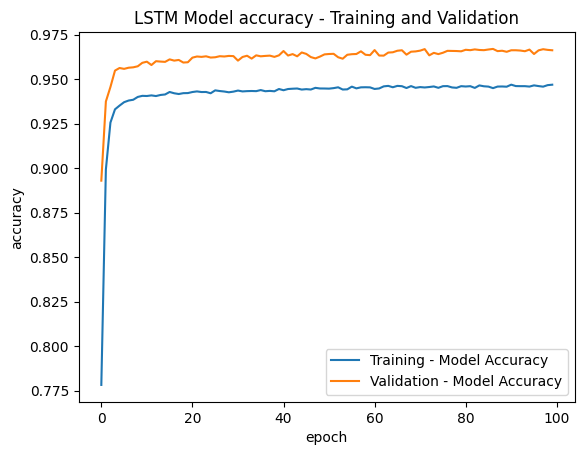

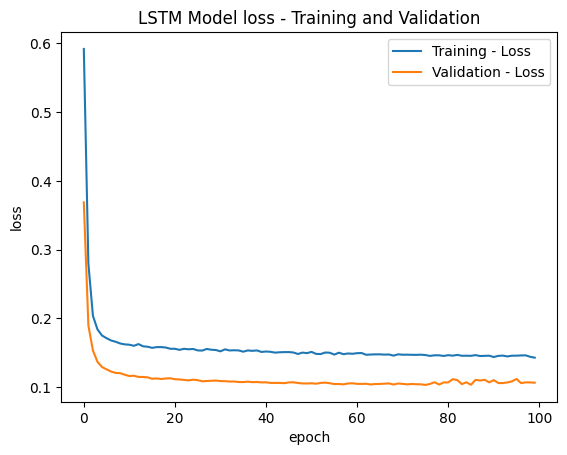

LSTM Classification report
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      8993
           1       0.96      0.98      0.97      9572

    accuracy                           0.97     18565
   macro avg       0.97      0.97      0.97     18565
weighted avg       0.97      0.97      0.97     18565

LSTM Confusion Matrix
[[8556  437]
 [ 160 9412]]
Accuracy Score        =     0.9678427147858875
Precision Score       =     0.9556300131993096
Recall/Sensitivity    =     0.9832845800250731
Specificity           =     0.9514066496163683
F1 Score              =     0.9692600792956079


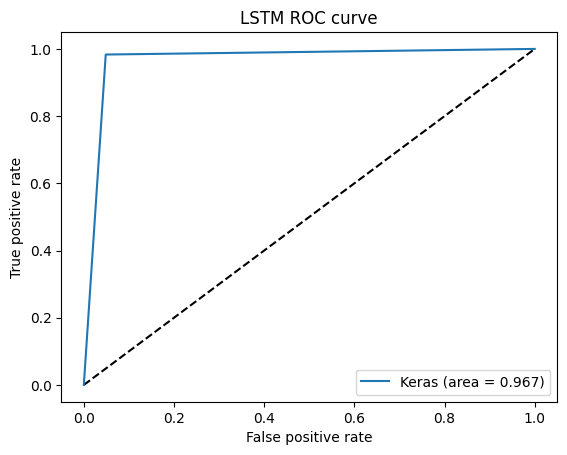

In [44]:
model.summary()

y_pred = (model.predict(X_test) > 0.5).astype("int32")
#y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('LSTM Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted.history['loss'], label="Training - Loss")
plt.plot(predicted.history['val_loss'], label="Validation - Loss")
plt.title('LSTM Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("LSTM Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("LSTM Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LSTM ROC curve')
plt.legend(loc='best')
plt.show()


In [45]:
tf.keras.utils.plot_model(model, to_file='LSTM.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## GRU

In [46]:
#create model (GRU)
# For stacked Layer
model1 = Sequential()
model1.add(GRU(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model1.add(GRU(128, dropout=0.3, return_sequences=True)) #128
model1.add(GRU(64, dropout=0.3, return_sequences=True)) #64
model1.add(GRU(32))#32

'''
(For Single Layer)
model1.add(GRU(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model1.add(GRU(128))
'''

model1.add((Dense(2, activation='softmax')))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=2785, callbacks=callbacks_list)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8603
Epoch 1: val_accuracy improved from -inf to 0.93078, saving model to weights.best.hdf5
40/40 [==============================] - 23s 317ms/step - loss: 0.4179 - accuracy: 0.8603 - val_loss: 0.2101 - val_accuracy: 0.9308
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9198
Epoch 2: val_accuracy improved from 0.93078 to 0.94021, saving model to weights.best.hdf5
40/40 [==============================] - 10s 256ms/step - loss: 0.2178 - accuracy: 0.9198 - val_loss: 0.1601 - val_accuracy: 0.9402
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9304
Epoch 3: val_accuracy improved from 0.94021 to 0.95335, saving model to weights.best.hdf5
40/40 [==============================] - 10s 247ms/step - loss: 0.1887 - accuracy: 0.9304 - val_loss: 0.1412 - val_accuracy: 0.9534
Epoch 4/100
40/40 [==============================] -

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 256)            269568    
                                                                 
 gru_1 (GRU)                 (None, 1, 128)            148224    
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             37248     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 464,514
Trainable params: 464,514
Non-trainable params: 0
_________________________________________________________________
581/581 [==============================] - 5s 4m

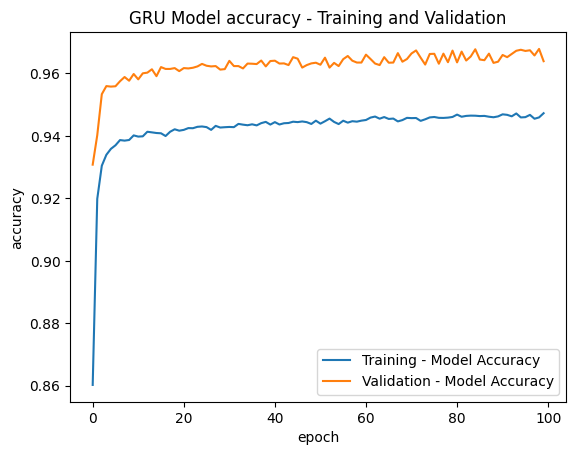

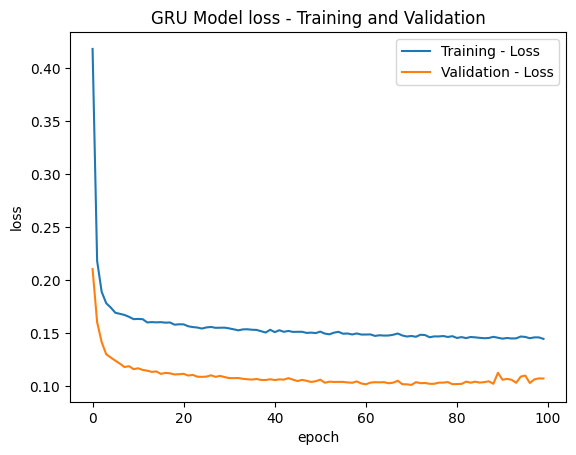

GRU Classification report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      8993
           1       0.95      0.99      0.97      9572

    accuracy                           0.96     18565
   macro avg       0.97      0.96      0.96     18565
weighted avg       0.97      0.96      0.96     18565

GRU Confusion Matrix
[[8475  518]
 [ 140 9432]]
Accuracy Score        =     0.9645569620253165
Precision Score       =     0.9479396984924623
Recall/Sensitivity    =     0.985374007521939
Specificity           =     0.942399644167686
F1 Score              =     0.9662944370453848


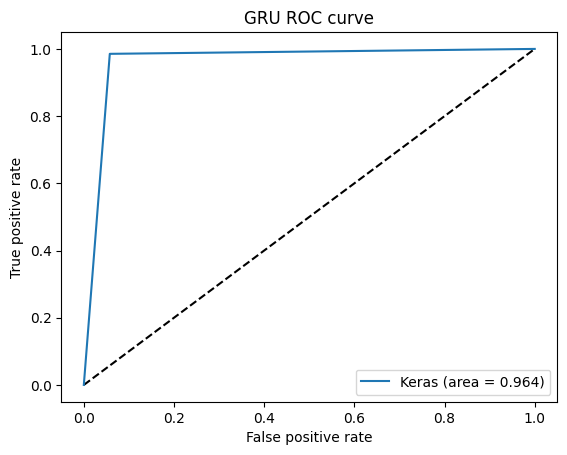

In [47]:
model1.summary()

y_pred = (model1.predict(X_test) > 0.5).astype("int32")
#y_pred = model1.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted1.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted1.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('GRU Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted1.history['loss'], label="Training - Loss")
plt.plot(predicted1.history['val_loss'], label="Validation - Loss")
plt.title('GRU Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("GRU Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("GRU Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('GRU ROC curve')
plt.legend(loc='best')
plt.show()


In [48]:
tf.keras.utils.plot_model(model1, to_file='GRU.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## MLP

In [56]:
#MLP
model4 = Sequential()
model4.add(Dense(256, activation='relu', input_shape=(1, X.shape[1])))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(2, activation='softmax'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted4= model4.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=2785, callbacks=callbacks_list)

Epoch 1/100
39/40 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.9125
Epoch 1: val_accuracy improved from -inf to 0.94942, saving model to weights.best.hdf5
40/40 [==============================] - 5s 84ms/step - loss: 0.3072 - accuracy: 0.9132 - val_loss: 0.1443 - val_accuracy: 0.9494
Epoch 2/100
39/40 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9571
Epoch 2: val_accuracy improved from 0.94942 to 0.96364, saving model to weights.best.hdf5
40/40 [==============================] - 1s 32ms/step - loss: 0.1305 - accuracy: 0.9571 - val_loss: 0.1022 - val_accuracy: 0.9636
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9644
Epoch 3: val_accuracy improved from 0.96364 to 0.96865, saving model to weights.best.hdf5
40/40 [==============================] - 2s 39ms/step - loss: 0.1067 - accuracy: 0.9644 - val_loss: 0.0950 - val_accuracy: 0.9687
Epoch 4/100
39/40 [============================>.] - ETA: 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1, 256)            24064     
                                                                 
 dense_9 (Dense)             (None, 1, 128)            32896     
                                                                 
 dense_10 (Dense)            (None, 1, 64)             8256      
                                                                 
 dense_11 (Dense)            (None, 1, 32)             2080      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                

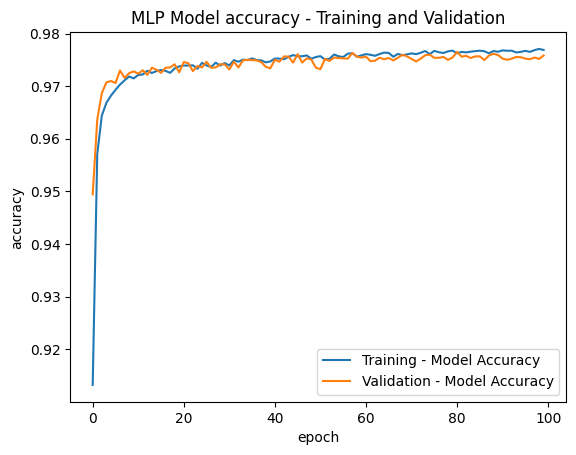

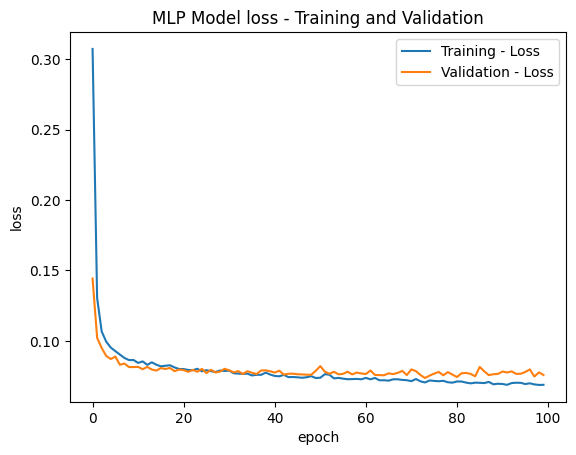

MLP Classification report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8960
           1       0.97      0.99      0.98      9605

    accuracy                           0.98     18565
   macro avg       0.98      0.98      0.98     18565
weighted avg       0.98      0.98      0.98     18565

MLP Confusion Matrix
[[8690  270]
 [ 135 9470]]
Accuracy Score        =     0.9781847562617829
Precision Score       =     0.9722792607802875
Recall/Sensitivity    =     0.9859448204060385
Specificity           =     0.9698660714285714
F1 Score              =     0.9790643577151718


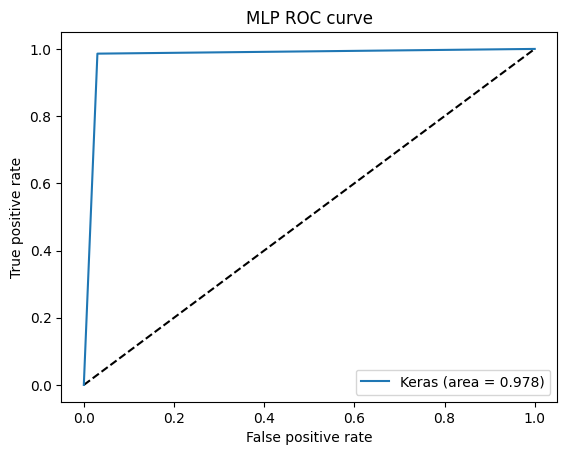

In [57]:
model4.summary()

y_pred = (model4.predict(X_test) > 0.5).astype("int32")
#y_pred = model4.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted4.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted4.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('MLP Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted4.history['loss'], label="Training - Loss")
plt.plot(predicted4.history['val_loss'], label="Validation - Loss")
plt.title('MLP Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("MLP Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("MLP Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('MLP ROC curve')
plt.legend(loc='best')
plt.show()


In [58]:
tf.keras.utils.plot_model(model4, to_file='MLP.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## GAN

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, UpSampling1D
from keras.callbacks import ModelCheckpoint

# Generator
generator = Sequential()
generator.add(Dense(256, input_shape=(1, X.shape[1])))
generator.add(Dense(128))
generator.add(Dense(64))
generator.add(Dense(X.shape[1]))
generator.add(Reshape((1, X.shape[1])))

# Discriminator
discriminator = Sequential()
discriminator.add(Conv1D(filters=256, kernel_size=1, activation='tanh', dtype='float32', input_shape=(1,X.shape[1])))
discriminator.add(Conv1D(filters=128, kernel_size=1, activation='tanh'))
discriminator.add(Conv1D(filters=64, kernel_size=1, activation='tanh'))
discriminator.add(Conv1D(filters=32, kernel_size=1, activation='tanh'))
discriminator.add(Flatten())
discriminator.add(Dense(100, activation='relu'))
discriminator.add(Dense(2, activation='sigmoid'))

# GAN
model5 = Sequential()
model5.add(generator)
model5.add(discriminator)

# Compile discriminator separately
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Freeze discriminator layers when training GAN
discriminator.trainable = False

# Compile GAN
model5.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN model
predicted5 = model5.fit(X_train, Y_train, epochs=100, batch_size=2785, validation_data=(X_val, Y_val))

Epoch 1/100
40/40 [==============================] - 5s 80ms/step - loss: 0.4217 - val_loss: 0.3592
Epoch 2/100
40/40 [==============================] - 2s 61ms/step - loss: 0.3500 - val_loss: 0.3366
Epoch 3/100
40/40 [==============================] - 2s 62ms/step - loss: 0.3323 - val_loss: 0.3231
Epoch 4/100
40/40 [==============================] - 3s 66ms/step - loss: 0.3229 - val_loss: 0.3146
Epoch 5/100
40/40 [==============================] - 3s 64ms/step - loss: 0.3141 - val_loss: 0.3067
Epoch 6/100
40/40 [==============================] - 3s 65ms/step - loss: 0.3090 - val_loss: 0.3034
Epoch 7/100
40/40 [==============================] - 3s 70ms/step - loss: 0.3063 - val_loss: 0.3014
Epoch 8/100
40/40 [==============================] - 3s 80ms/step - loss: 0.3042 - val_loss: 0.2999
Epoch 9/100
40/40 [==============================] - 3s 80ms/step - loss: 0.3026 - val_loss: 0.2988
Epoch 10/100
40/40 [==============================] - 4s 90ms/step - loss: 0.3015 - val_loss: 0.2977

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1, 93)             71261     
                                                                 
 sequential_1 (Sequential)   (None, 2)                 70798     
                                                                 
Total params: 142,059
Trainable params: 71,261
Non-trainable params: 70,798
_________________________________________________________________
581/581 [==============================] - 2s 3ms/step
(18565, 2)
[[0 1]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


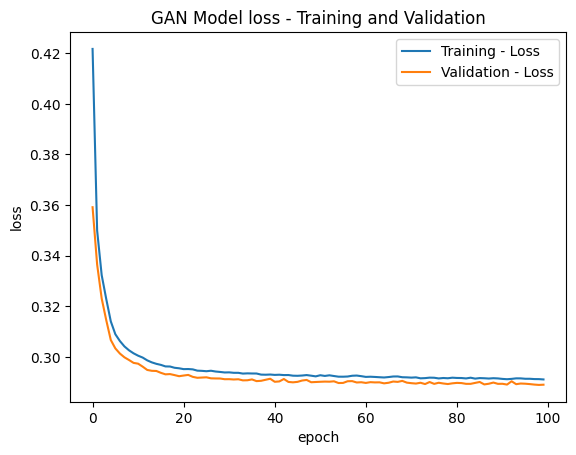

GAN Classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8960
           1       0.97      0.97      0.97      9605

    accuracy                           0.97     18565
   macro avg       0.97      0.97      0.97     18565
weighted avg       0.97      0.97      0.97     18565

GAN Confusion Matrix
[[8644  316]
 [ 258 9347]]
Accuracy Score        =     0.9690816051710207
Precision Score       =     0.9672979405981579
Recall/Sensitivity    =     0.973138990109318
Specificity           =     0.9647321428571428
F1 Score              =     0.9702096740709985


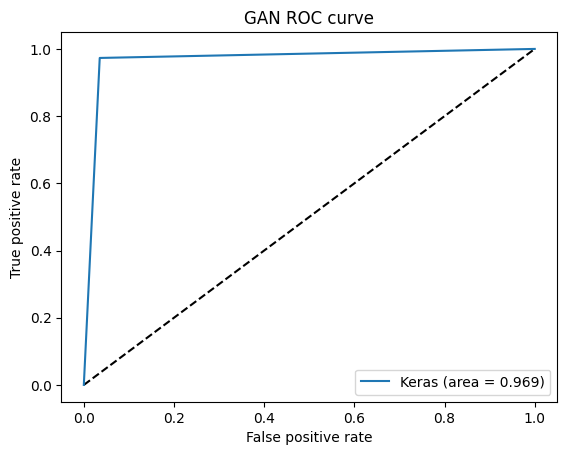

In [43]:
model5.summary()

y_pred = (model5.predict(X_test) > 0.5).astype("int32")
#y_pred = model5.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted5.history['loss'], label="Training - Loss")
plt.plot(predicted5.history['val_loss'], label="Validation - Loss")
plt.title('GAN Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("GAN Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("GAN Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('GAN ROC curve')
plt.legend(loc='best')
plt.show()

In [44]:
tf.keras.utils.plot_model(generator, to_file='GANg.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [45]:
tf.keras.utils.plot_model(discriminator, to_file='GANd.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
tf.keras.utils.plot_model(model5, to_file='GAN.png', show_shapes=True, show_layer_activations=True, show_dtype=True, show_layer_names=True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Visualisation Comparision

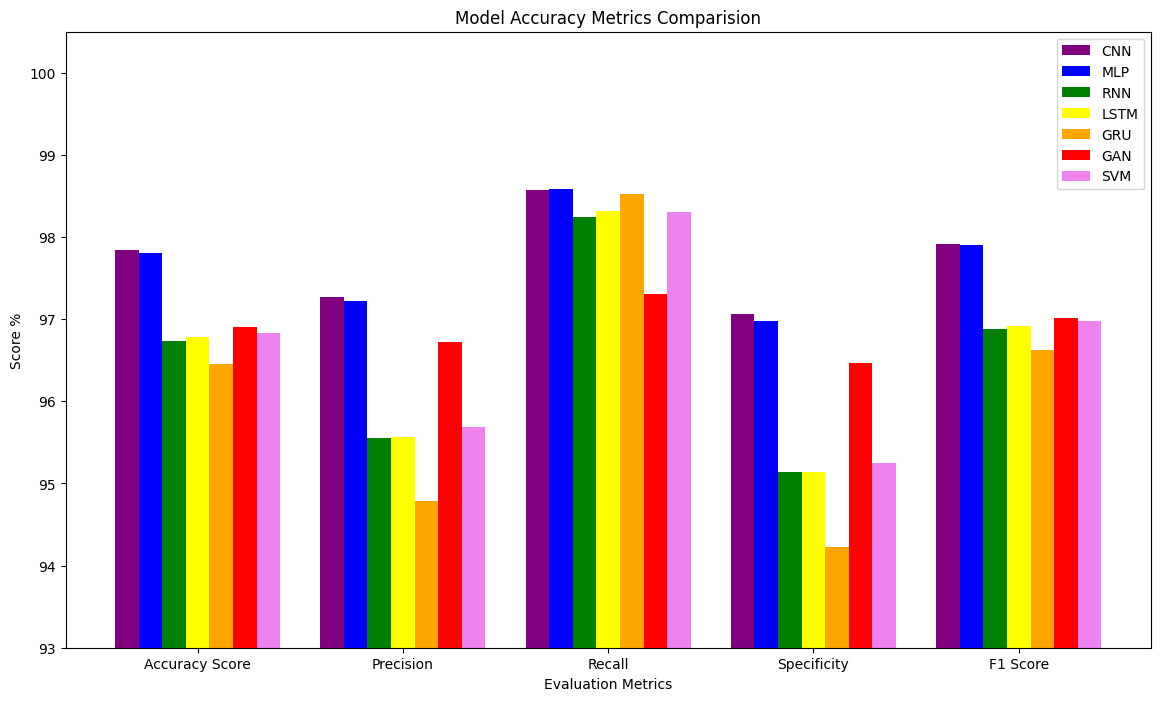

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 5
ind = np.arange(N)
width = 0.115

CNN  = [97.84,97.27,98.57,97.06,97.92]
MLP  = [97.81,97.22,98.59,96.98,97.90]
RNN  = [96.74,95.55,98.24,95.14,96.88]
LSTM = [96.78,95.56,98.32,95.14,96.92]
GRU  = [96.45,94.79,98.53,94.23,96.62]
GAN  = [96.90,96.72,97.31,96.47,97.02]
SVM  = [96.83,95.69,98.30,95.25,96.98]

bar1 = plt.bar(ind, CNN, width, color = 'purple')
bar2 = plt.bar(ind+width, MLP, width, color='blue')
bar3 = plt.bar(ind+width*2, RNN, width, color = 'green')
bar4 = plt.bar(ind+width*3, LSTM, width, color = 'yellow')
bar5 = plt.bar(ind+width*4, GRU, width, color = 'orange')
bar6 = plt.bar(ind+width*5, GAN, width, color = 'red')
bar7 = plt.bar(ind+width*6, SVM, width, color = 'violet')

plt.xlabel("Evaluation Metrics")
plt.ylabel('Score %')
plt.title("Model Accuracy Metrics Comparision")

plt.xticks(ind+width*3,['Accuracy Score', 'Precision', 'Recall', 'Specificity', 'F1 Score'])
plt.legend((bar1, bar2, bar3, bar4, bar5, bar6, bar7, ), ('CNN', 'MLP', 'RNN', 'LSTM', 'GRU', 'GAN', 'SVM'), loc="upper right" )
plt.ylim(93,100.5)
plt.gcf().set_size_inches(14, 8)
#plt.axhline(y = 100, color = 'grey', linestyle = '--')

plt.show()